# 1. Data Ingestion and Preprocess


In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

outcome_dict = {
'normal': 'normal',
'back': 'DoS',
'land': 'DoS',
'neptune': 'DoS',
'pod': 'DoS',
'smurf': 'DoS',
'teardrop': 'DoS',
'mailbomb': 'DoS',
'apache2': 'DoS',
'processtable': 'DoS',
'udpstorm': 'DoS',
'ipsweep': 'Probe',
'nmap': 'Probe',
'portsweep': 'Probe',
'satan': 'Probe',
'mscan': 'Probe',
'saint': 'Probe',
'ftp_write': 'R2L',
'guess_passwd': 'R2L',
'imap': 'R2L',
'multihop': 'R2L',
'phf': 'R2L',
'spy': 'R2L',
'warezclient': 'R2L',
'warezmaster': 'R2L',
'sendmail': 'R2L',
'named': 'R2L',
'snmpgetattack': 'R2L',
'snmpguess': 'R2L',
'xlock': 'R2L',
'xsnoop': 'R2L',
'worm': 'R2L',
'buffer_overflow': 'U2R',
'loadmodule': 'U2R',
'perl': 'U2R',
'rootkit': 'U2R',
'httptunnel': 'U2R',
'ps': 'U2R',
'sqlattack': 'U2R',
'xterm': 'U2R'
}

outcome_dict_numeric = {
"normal": 1.0,
"DoS": 2.0,
"Probe": 3.0,
"R2L": 4.0,
"U2R": 5.0
}
outcome_names = ["normal","DoS","Probe","R2L","U2R"]
outcome_names_int = [1.0,2.0,3.0,4.0,5.0]

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
  def __init__(self):
    super().__init__()

  def _transform(self, dataset):
    label_to_binary = udf(lambda name:outcome_dict_numeric[outcome_dict[name]])
    output_df = dataset.withColumn('outcome',label_to_binary(col('class'))).drop("class")
    output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
    output_df = output_df.drop('difficulty')
    return output_df


class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')


    # Stage for creating the outcome column representing whether there is attack
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline

## 2.1 Load the training and test dataframe using the pipeline

In [2]:
import findspark
findspark.init()
findspark.find()

import os
import sys

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("IntrusionDetectionProject") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('./KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('./KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)



In [4]:
nslkdd_df.printSchema()
nslkdd_df.show()


root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[1,13,14,17,...|    1.0|
|(113,[1,13,14,17,...|    1.0|
|(113,[13,14,15,17...|    2.0|
|(113,[1,2,13,14,1...|    1.0|
|(113,[1,2,13,14,1...|    1.0|
|(113,[13,14,16,17...|    2.0|
|(113,[13,14,15,17...|    2.0|
|(113,[13,14,15,17...|    2.0|
|(113,[13,14,15,17...|    2.0|
|(113,[13,14,15,17...|    2.0|
|(113,[13,14,16,17...|    2.0|
|(113,[13,14,15,17...|    2.0|
|(113,[1,2,13,14,1...|    1.0|
|(113,[1,13,14,17,...|    4.0|
|(113,[13,14,15,18...|    2.0|
|(113,[13,14,15,17...|    2.0|
|(113,[1,2,13,14,1...|    1.0|
|(113,[1,13,14,17,...|    3.0|
|(113,[1,2,13,14,1...|    1.0|
|(113,[1,2,13,14,1...|    1.0|
+--------------------+-------+
only showing top 20 rows



In [4]:
nslkdd_df_test.printSchema()
nslkdd_df_test.show(1)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[13,14,16,17...|    2.0|
+--------------------+-------+
only showing top 1 row



## Random Forest Classifier For Benchmarking

In [8]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol='features', labelCol='outcome')

rf_model = rf.fit(nslkdd_df)

train_pred = rf_model.transform(nslkdd_df)
test_pred = rf_model.transform(nslkdd_df_test)

evaluator = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy")

train_acc = evaluator.evaluate(train_pred)
test_acc = evaluator.evaluate(test_pred)

print(f"Train: {train_acc}")
print(f"Test: {test_acc}")

Train: 0.9641907392854024
Test: 0.7088804116394606


Text(0.5, 25.722222222222214, 'Predicted')

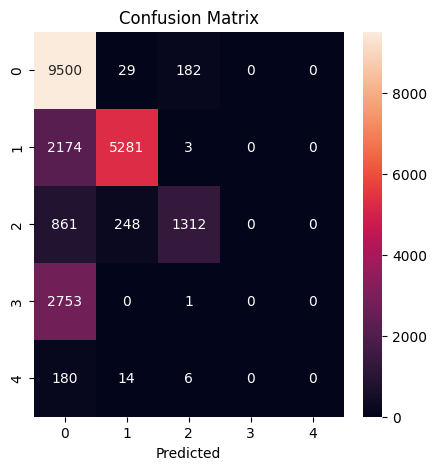

In [6]:
predictions_pd = test_pred.select('outcome', 'prediction').toPandas()

# import plt
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions_pd['outcome'], predictions_pd['prediction'])
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')


In [7]:
# Reduce the dataset size to run grid search
reduced_nslkdd_df = nslkdd_df.sample(False, 0.2, 57)
reduced_nslkdd_df_test = nslkdd_df_test.sample(False, 0.2, 57)

In [8]:
# Perform a grid search to find the best hyperparameters
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [5, 15, 25])
                .addGrid(rf.impurity, ["gini", "entropy"])
                .addGrid(rf.minInstancesPerNode, [1, 5, 10])
                .addGrid(rf.numTrees, [5, 50, 100])
                .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(reduced_nslkdd_df)

train_pred = cv_model.transform(reduced_nslkdd_df)
test_pred = cv_model.transform(reduced_nslkdd_df_test)

train_acc = evaluator.evaluate(train_pred)
test_acc = evaluator.evaluate(test_pred)

print(f"Train Acc: {train_acc}")
print(f"Test Acc: {test_acc}")

Train Acc: 0.9988493889858753
Test Acc: 0.738177874186551


Text(0.5, 25.722222222222214, 'Predicted')

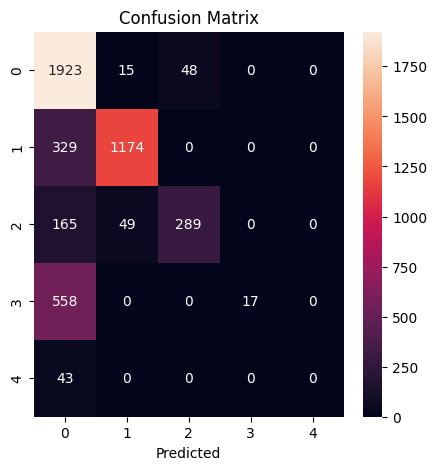

In [9]:
predictions_pd = test_pred.select('outcome', 'prediction').toPandas()

# import plt
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions_pd['outcome'], predictions_pd['prediction'])
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')

In [11]:
# final model parameters
best_model = cv_model.bestModel
print('Best Param (Max Depth): ', best_model._java_obj.getMaxDepth())
print('Best Param (Impurity): ', best_model._java_obj.getImpurity())
print('Best Param (Min Instances Per Node): ', best_model._java_obj.getMinInstancesPerNode())
print('Best Param (Num Trees): ', best_model._java_obj.getNumTrees())

Best Param (Max Depth):  25
Best Param (Impurity):  gini
Best Param (Min Instances Per Node):  1
Best Param (Num Trees):  100


## Undersampling other features to balance the dataset

In [14]:
# Undersample the dataset to balance the classes
min_count = nslkdd_df.groupBy('outcome').count().agg({"count": "min"}).collect()[0][0]
print(min_count)

balance_df = nslkdd_df.sampleBy('outcome', fractions={1.0: min_count/67343, 2.0: min_count/45927, 3.0: min_count/11656, 4.0: min_count/995, 5.0: min_count/52})

52


In [7]:
balance_df.groupBy('outcome').count().show()

+-------+-----+
|outcome|count|
+-------+-----+
|    1.0|   45|
|    4.0|   48|
|    3.0|   46|
|    2.0|   61|
|    5.0|   52|
+-------+-----+



In [12]:
# Train the model on the balanced dataset
rf = RandomForestClassifier(featuresCol='features', labelCol='outcome', maxDepth=25, impurity='gini', minInstancesPerNode=1, numTrees=100)
rf_model = rf.fit(balance_df)

train_pred = rf_model.transform(balance_df)
test_pred = rf_model.transform(nslkdd_df_test)

train_acc = evaluator.evaluate(train_pred)
test_acc = evaluator.evaluate(test_pred)

print(f"Train: {train_acc}")
print(f"Test: {test_acc}")

Train: 1.0
Test: 0.7644162526614621


Text(0.5, 25.722222222222214, 'Predicted')

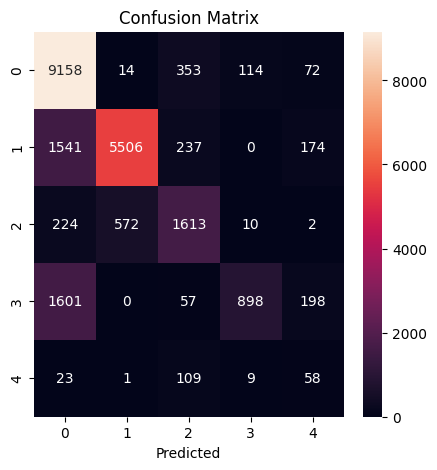

In [13]:
predictions_pd = test_pred.select('outcome', 'prediction').toPandas()

# import plt
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions_pd['outcome'], predictions_pd['prediction'])
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')

## Convert to pytorch tensors

In [15]:
from pyspark.sql.types import DoubleType, ArrayType
from pyspark.sql.functions import udf
import pandas as pd

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))
train_pd = balance_df.withColumn("features", to_array("features")).toPandas()
test_pd = nslkdd_df_test.withColumn("features", to_array("features")).toPandas()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

x_train = torch.from_numpy(np.array(train_pd['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(train_pd['outcome'].values.tolist(), np.int64))

x_test = torch.from_numpy(np.array(test_pd['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(test_pd['outcome'].values.tolist(), np.int64))

In [17]:
y_train = y_train - 1
y_test = y_test - 1
print(y_train.unique())

tensor([0, 1, 2, 3, 4])


In [18]:
print(x_train.shape, y_train.shape)

torch.Size([259, 113]) torch.Size([259])


In [19]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

## MLP training

In [8]:
class myNeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.ln1 = nn.Linear(input_size, 128)
        self.ln2 = nn.Linear(128, 64)
        self.ln3 = nn.Linear(64, 32)
        self.ln4 = nn.Linear(32, 5)
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.relu(self.ln3(x))
        x = self.ln4(x)
        x = F.softmax(x, dim=-1)
        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
input_size = x_train.shape[1]
model = myNeuralNet(input_size).to(device)

batch_size = 64
num_epochs = 200
lr = 0.0001
opt = optim.Adam(model.parameters(), lr=lr)
loss_fcn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Initialize variables to store the total loss for this epoch
    total_train_loss = 0
    total_test_loss = 0
    correct_predictions = 0
    total_predictions = 0
    # Training loop
    for batch_id, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)  # Move the data to the device that is used
        opt.zero_grad()  # Zero the gradients
        output = model(x)  # Forward pass
        loss = loss_fcn(output, y)  # Compute the loss

        total_train_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(output.data, 1)  # Get the predicted classes
        total_predictions += y.size(0)
        correct_predictions += (predicted == y).sum().item()
        loss.backward()  # Backward pass
        opt.step()  # Update the parameters

    # Store the average training loss for this epoch
    train_loss.append(total_train_loss / len(train_loader))
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1} - Train Accuracy: {correct_predictions / total_predictions}")
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for batch_id, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)  # Move the data to the device that is used
            output = model(x)  # Forward pass
            loss = loss_fcn(output, y )  # Compute the loss
            total_test_loss += loss.item()  # Accumulate the loss
            _, predicted = torch.max(output.data, 1)
            total_predictions += y.size(0)
            correct_predictions += (predicted == y).sum().item()

    # Store the average validation loss for this epoch
    test_loss.append(total_test_loss / len(test_loader))

    # Print the losses every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")
        print(f"Epoch {epoch + 1} - Test Accuracy: {correct_predictions / total_predictions}")

    # Save the best model so far
    if epoch == 0 or test_loss[-1] < np.min(test_loss[:-1]):
        best_model = model
        best_epoch = epoch

    # Early stopping
    if epoch - best_epoch >= 30:
        print(f"Early stopping at epoch {epoch + 1}")
        break

Epoch 5 - Train Accuracy: 0.33976833976833976
Epoch 5 - Train Loss: 1.6049132347106934, Test Loss: 1.6126111229148195
Epoch 5 - Test Accuracy: 0.28743789921930446
Epoch 10 - Train Accuracy: 0.444015444015444
Epoch 10 - Train Loss: 1.5962122678756714, Test Loss: 1.611453367697956
Epoch 10 - Test Accuracy: 0.3042051100070972
Epoch 15 - Train Accuracy: 0.5057915057915058
Epoch 15 - Train Loss: 1.585201907157898, Test Loss: 1.61030422053999
Epoch 15 - Test Accuracy: 0.3031848828956707
Epoch 20 - Train Accuracy: 0.5752895752895753
Epoch 20 - Train Loss: 1.5695278882980346, Test Loss: 1.6087947324044982
Epoch 20 - Test Accuracy: 0.3206618168914124
Epoch 25 - Train Accuracy: 0.6023166023166023
Epoch 25 - Train Loss: 1.5474956035614014, Test Loss: 1.6063894536610028
Epoch 25 - Test Accuracy: 0.2954222853087296
Epoch 30 - Train Accuracy: 0.6023166023166023
Epoch 30 - Train Loss: 1.5199326038360597, Test Loss: 1.6019350678657338
Epoch 30 - Test Accuracy: 0.2825585521646558
Epoch 35 - Train Accur

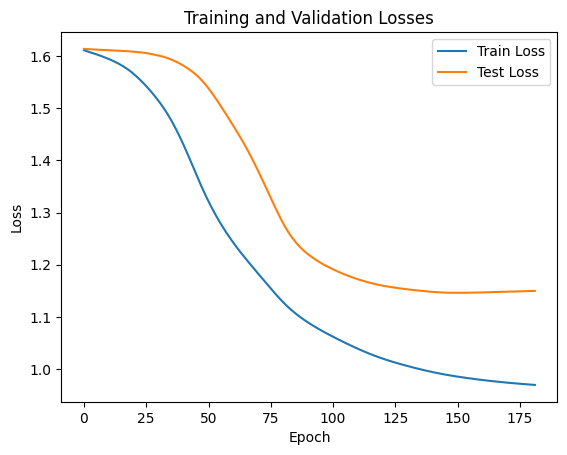

In [25]:
# Plot the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Losses")
plt.show()